# Introduction
###### Created by [Roberto Mora](https://github.com/romogo17)

`pgcv` is a PostgreSQL extension for Computer Vision from the database server. It aims to be an extension that implements several image manipulation algorithms to store and manipulate images from the database server.

## How `pgcv` came to be?
This extension was born in the [National University Costa Rica](https://www.una.ac.cr/) as one of the main products of the project SIA0511-16 "Databases for the storage and analysis of digital mammograms" proposed by the professor MSc. Johnny Villalobos.

The extension was designed and developed by me, Roberto Mora. The first version has the purpose of creating a database for storing mammograms and information about patients using the `pgcv` data types. The project specifies the extension should be able to perform image segmentation on the images, to later extract objects from them that would be analyzed by geometric features.

However, I have tried to generalize the extension for other areas of Computer Vision (hence the name) hoping I can add new algorithms later on, not only those used for mammogram analysis.

Up until version 1.0 this extension represents my contribution to the project SIA0511-16. From there, I maintain this extension independently.

## Background

As part of the research process in extending PostgreSQL, a first prototype of this extension was made using C hoping to study how the native extensions with base types worked. Here are some things I learnt from this prototype:

1. Base extensions only make sense, when the datatype itself and its representation have a semantic meaning without needing additional functions.

One example of this is the datatype that the PostgreSQL documentation uses as example of a base type: `text`.
```c
typedef struct {
    int32 length;
    char data[FLEXIBLE_ARRAY_MEMBER];
} text;
```
The `text` datatype has a meaning of its own. We don't need to ask for any attribute given a `text` type, its meaning is axiomatic.

Defining complex structures as base types would require to create several functions to access its atributes, since PostgreSQL treats this structures as chunks of memory without any consideration of its internal structures.

2. The process of using, dynamic arrays, returning arrays, returning sets... requires a lot of boilerplate and careful memory management.

Using dynamic arrays of structured base types from C isn't an easy task. It requires a lot of considerations only to use the types: TOAST, `FLEXIBLE_ARRAY_MEMBER`, `varlena` structures (header, data, etc.), deTOAST, storage, copying, array constructing and deconstructing, `Oid`s, memory corruption, testing.
All this considerations have to be taken into account when implementing the data manipulation algorithms required by the extension which made the development process a lot slower.

With this in mind, when starting to design the real extension I decided not to make it a 100% native extension and instead implement most of it using PL/pgSQL.

The approach I was going to use for this purpose was to create a "Tensor-like" datatype in PL/pgSQL that would describe an N dimensional array to represent the images.

However, I thought this would require me to create a set of functions for N dimensional array manipulation and then create the specific algorithms required by the project's domain so I started to look for options and, after having read about a hundred pages of the PostgreSQL documentation about extending SQL, I arrived to the PL/Python section, which immediately caught my attention because this means I could use the wonderful N dimensional arrays provided by `numpy.ndarray`

This made manipulating the images, structures and arrays a lot easier and faster. Also, I'm quite interested in Deep Learning so I've been wanting to use Python more for a while

image shape:  [1024, 1024]  image data:  [0 0 0 ... 0 0 0]


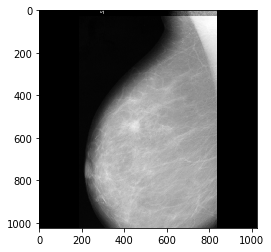

In [5]:
import numpy as np
from scipy import signal 
from PIL import Image

img = PIL.Image.open('data/mdb155.pgm')
img = np.array(img)
med = signal.medfilt(img, 3)

import matplotlib.pyplot as plt
plt.imshow(med, cmap = plt.get_cmap('gray'))

print("image shape: ", list(img.shape), " image data: ", np.ravel(img))


## Packages used

This extension uses `numpy`, `scipy` and `scikit-image`. From the documentation:

- NumPy’s array type augments the Python language with an efficient data structure useful for numerical work, e.g., manipulating matrices. NumPy also provides basic numerical routines, such as tools for finding eigenvectors.
- SciPy contains additional routines needed in scientific work: for example, routines for computing integrals numerically, solving differential equations, optimization, and sparse matrices.

Aditionally, `Pillow` is used in order to support multiple file formats for reading images into `ndarray`s. This is a list of the supported file formats of Pillow

- Fully supported formats
    1. BMP
    1. EPS
    1. GIF
    1. ICNS
    1. ICO
    1. IM
    1. JPEG and JPEG 2000
    1. MSP
    1. PCX
    1. PNG
    1. PPM (which includes PGM files)
    1. SGI
    1. SPIDER
    1. TGA
    1. TIFF
    1. WebP
    1. XBM
- Read-only formats
    1. BLP
    1. CUR
    1. DCX
    1. DDS
    1. FLI, FLC
    1. FPX
    1. FTEX
    1. GBR
    1. GD
    1. IMT
    1. IPTC / NAA
    1. MCIDAS
    1. MIC
    1. MPO
    1. PCD
    1. PIXAR
    1. PSD
    1. WAL
    1. XPM
- Write-only formats
    1. BUFR
    1. FITS
    1. GRIB
    1. HDF5
    1. MPEG
    1. WMF


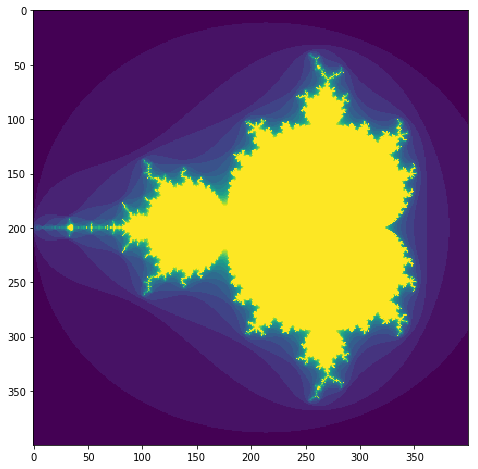

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def mandelbrot( h,w, maxit=20 ):
    """Returns an image of the Mandelbrot fractal of size (h,w)."""
    y,x = np.ogrid[ -1.4:1.4:h*1j, -2:0.8:w*1j ]
    c = x+y*1j
    z = c
    divtime = maxit + np.zeros(z.shape, dtype=int)

    for i in range(maxit):
        z = z**2 + c
        diverge = z*np.conj(z) > 2**2         # who is diverging
        div_now = diverge & (divtime==maxit)  # who is diverging now
        divtime[div_now] = i                  # note when
        z[diverge] = 2                        # avoid diverging too much

    return divtime

plt.figure(figsize=(8, 8))
plt.imshow(mandelbrot(400,400))
plt.show()